In [1]:
import math
import os
import copy
import mldatasets
import pandas as pd
import numpy as np
from sklearn import preprocessing, model_selection, metrics,\
                    linear_model, svm, neural_network, ensemble
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import tensorflow as tf
from bayes_opt import BayesianOptimization
import tensorflow_lattice as tfl
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import xai
import shap

In [ ]:
print(tf.__version__)

In [2]:
recidivism_df = mldatasets.load("recidivism-risk-balanced")

https://github.com/PacktPublishing/Interpretable-Machine-Learning-with-Python/raw/master/datasets/recidivism-risk_balanced.csv downloaded to /Users/serg/EXTEND/PROJECTS/InterpretableMLBook/programming/Chapter12/data/recidivism-risk_balanced.csv
1 dataset files found in /Users/serg/EXTEND/PROJECTS/InterpretableMLBook/programming/Chapter12/data folder
parsing /Users/serg/EXTEND/PROJECTS/InterpretableMLBook/programming/Chapter12/data/recidivism-risk_balanced.csv


There should be over 11,000 records and 11 columns. We can verify this was the case with `info()`:

In [3]:
recidivism_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11142 entries, 0 to 11141
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   sex                      11142 non-null  object 
 1   age                      11142 non-null  int64  
 2   race                     11142 non-null  object 
 3   juv_fel_count            11142 non-null  int64  
 4   juv_misd_count           11142 non-null  int64  
 5   juv_other_count          11142 non-null  int64  
 6   priors_count             11142 non-null  int64  
 7   c_charge_degree          11142 non-null  object 
 8   days_b_screening_arrest  11142 non-null  float64
 9   length_of_stay           11142 non-null  float64
 10  compas_score             11142 non-null  int64  
 11  is_recid                 11142 non-null  int64  
dtypes: float64(2), int64(7), object(3)
memory usage: 1.0+ MB


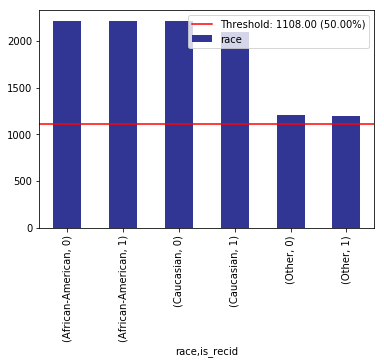

In [4]:
categorical_cols_l = ['sex', 'race', 'c_charge_degree',\
                      'is_recid', 'compas_score']
xai.imbalance_plot(recidivism_df, 'race', 'is_recid',\
                   categorical_cols=categorical_cols_l)

In [ ]:
recidivism_corr_df = recidivism_df.drop(['compas_score'], axis=1)
pd.DataFrame({'feature': recidivism_corr_df.columns[:-1],\
              'correlation_to_target': scipy.stats.spearmanr(recidivism_corr_df).correlation[10,:-1]\
             }).style.background_gradient(cmap='coolwarm')

![png](./Chapter12_files_extra/Fig_02.png)

In [6]:
recidivism_df.c_charge_degree.value_counts()

(F3)     6555
(M1)     2632
(F2)      857
(M2)      768
(F1)      131
(F7)      104
(MO3)      76
(F5)        7
(F6)        5
(NI0)       4
(CO3)       2
(TCX)       1
Name: c_charge_degree, dtype: int64

In [7]:
charge_degree_code_rank = {'(F10)': 15, '(F9)':14, '(F8)':13, '(F7)':12, '(TCX)':11, '(F6)':10, '(F5)':9,\
                           '(F4)':8, '(F3)':7, '(F2)':6, '(F1)':5, '(M1)':4, '(NI0)':4, '(M2)':3,\
                           '(CO3)':2, '(MO3)':1, '(X)':0}
recidivism_df.c_charge_degree.replace(charge_degree_code_rank, inplace=True)

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


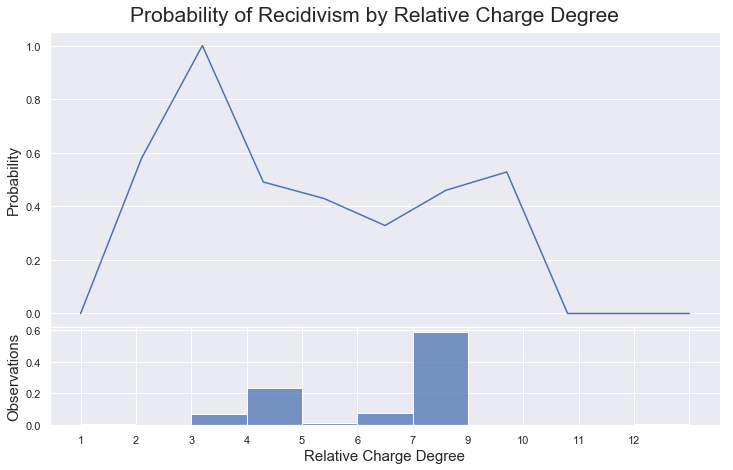

In [8]:
mldatasets.plot_prob_progression(recidivism_df.c_charge_degree, recidivism_df.is_recid,\
                    x_intervals=12, use_quartiles=False, xlabel='Relative Charge Degree',\
                    title='Probability of Recidivism by Relative Charge Degree')

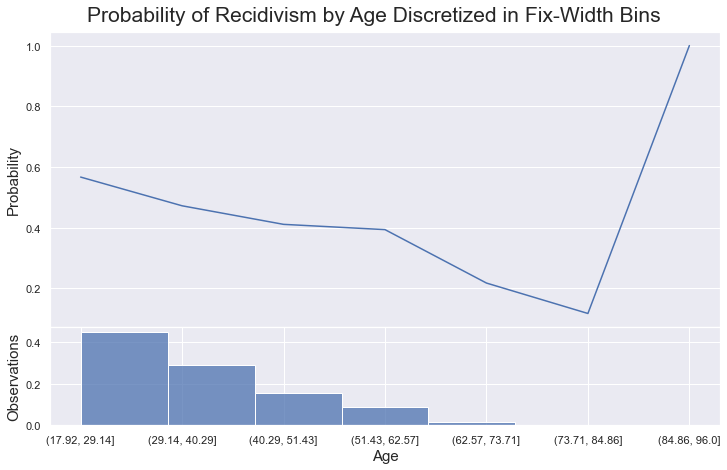

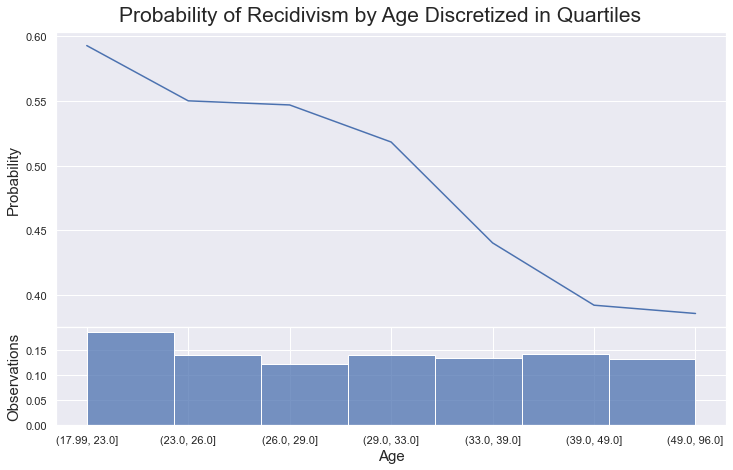

In [10]:
mldatasets.plot_prob_progression(recidivism_df.age, recidivism_df.is_recid,\
                                 x_intervals=7, use_quartiles=False, xlabel='Age',\
                title='Probability of Recidivism by Age Discretized in Fix-Width Bins')

mldatasets.plot_prob_progression(recidivism_df.age, recidivism_df.is_recid,\
                                 x_intervals=7, use_quartiles=True, xlabel='Age',\
                title='Probability of Recidivism by Age Discretized in Quartiles')

In [12]:
recidivism_df['age_group'] = pd.qcut(recidivism_df.age, 7, precision=0).astype(str)

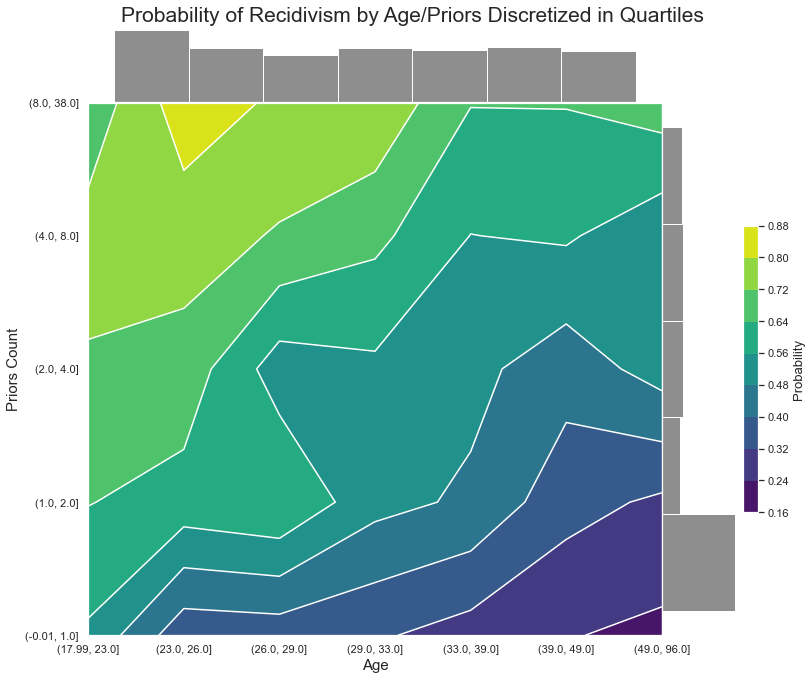

In [13]:
mldatasets.plot_prob_contour_map(recidivism_df.age, recidivism_df.priors_count, recidivism_df.is_recid,\
                                 use_quartiles=True, xlabel='Age', ylabel='Priors Count',\
                 title='Probability of Recidivism by Age/Priors Discretized in Quartiles')

In [ ]:
recidivism_df['priors_per_year'] = recidivism_df['priors_count']/(recidivism_df['age'] - 17)

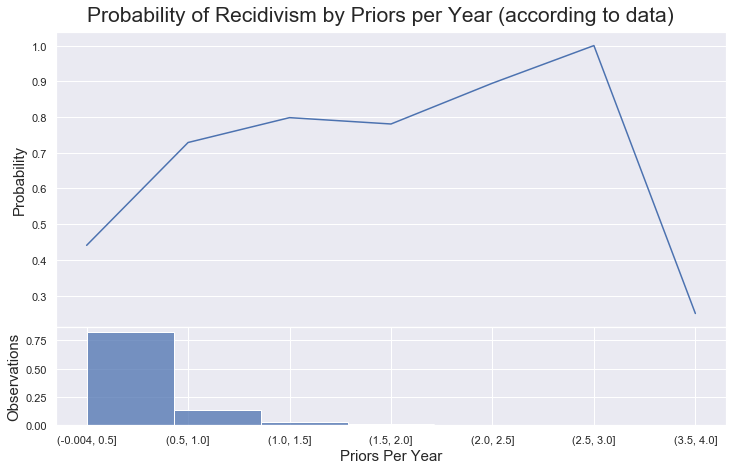

In [13]:
mldatasets.plot_prob_progression(recidivism_df.priors_per_year, recidivism_df.is_recid,\
                                 x_intervals=8, xlabel='Priors Per Year',\
            title='Probability of Recidivism by Priors per Year (according to data)')

In [14]:
recidivism_df.loc[recidivism_df.priors_per_year > 3, 'priors_per_year'] = -1

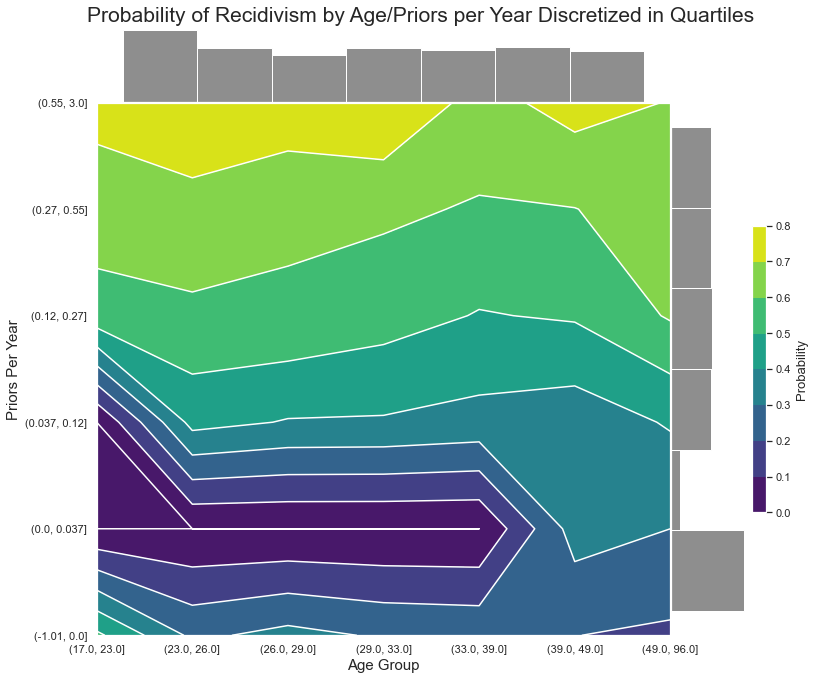

In [19]:
mldatasets.plot_prob_contour_map(recidivism_df.age_group, recidivism_df.priors_per_year,\
                                 recidivism_df.is_recid, y_intervals=6, use_quartiles=True,\
                                 xlabel='Age Group', ylabel='Priors Per Year',\
            title='Probability of Recidivism by Age/Priors per Year Discretized in Quartiles')

In [17]:
cat_feat_l = ['sex', 'race', 'age_group']
ordenc = preprocessing.OrdinalEncoder(dtype=np.int8)
recidivism_df[cat_feat_l] = ordenc.fit_transform(recidivism_df[cat_feat_l])
recidivism_df.drop(['age', 'priors_count', 'compas_score'], axis=1, inplace=True)

In [18]:
rand = 9
os.environ['PYTHONHASHSEED'] = str(rand)
tf.random.set_seed(rand)
np.random.seed(rand)

y = recidivism_df['is_recid']
X = recidivism_df.drop(['is_recid'], axis=1).copy()
X_train, X_test, y_train, y_test =\
        model_selection.train_test_split(X, y, test_size=0.2, random_state=rand)
recidivism_df = X.join(y)

In [ ]:
pd.DataFrame({'feature': X.columns,\
              'correlation_to_target': scipy.stats.spearmanr(recidivism_df).correlation[10,:-1]\
             }).style.background_gradient(cmap='coolwarm')

In [103]:
def build_nn_mdl(hidden_layer_sizes, l1_reg=0, l2_reg=0, dropout=0):
    nn_model = tf.keras.Sequential([
        tf.keras.Input(shape=[len(X_train.keys())]),
        tf.keras.layers.experimental.preprocessing.Normalization()
    ])
    reg_args = {}
    if (l1_reg > 0) or (l2_reg > 0):
        reg_args = {'kernel_regularizer':\
                    tf.keras.regularizers.l1_l2(l1=l1_reg, l2=l2_reg)}
    for hidden_layer_size in hidden_layer_sizes:
        nn_model.add(tf.keras.layers.Dense(hidden_layer_size,\
                                           activation='relu', **reg_args))
    if dropout > 0:
        nn_model.add(tf.keras.layers.Dropout(dropout))
    nn_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    nn_model.compile(loss='binary_crossentropy',\
                optimizer=tf.keras.optimizers.Adam(lr=0.0004),\
                metrics=['accuracy',tf.keras.metrics.AUC(name='auc')])
    
    return nn_model

In [183]:
cv = model_selection.RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=rand)
nn_grid = {'hidden_layer_sizes':[(80,)], 'l1_reg':[0,0.005],\
           'l2_reg':[0,0.01], 'dropout':[0,0.05]}
nn_model = KerasClassifier(build_fn=build_nn_mdl)
nn_grid_search = model_selection.GridSearchCV(estimator=nn_model, cv=cv, n_jobs=-1,\
                                           param_grid=nn_grid, scoring='precision',\
                                           error_score=0, verbose=0)
nn_grid_result = nn_grid_search.fit(X_train.astype(float), y_train.astype(float),\
                        epochs=400, batch_size=128, verbose=0)

CPU times: user 40.8 s, sys: 10.9 s, total: 51.7 s
Wall time: 17min 22s


In [164]:
print(nn_grid_result.best_params_)

{'dropout': 0.05, 'hidden_layer_sizes': (80,), 'l1_reg': 0.005, 'l2_reg': 0.01}


In [ ]:
pd.DataFrame(nn_grid_result.cv_results_)\
    [['param_hidden_layer_sizes','param_l1_reg', 'param_l2_reg', 'param_dropout',\
      'mean_test_score', 'std_test_score', 'rank_test_score']].\
    sort_values(by='rank_test_score')

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Instructions for updating:
Please use `model.predict()` instead.


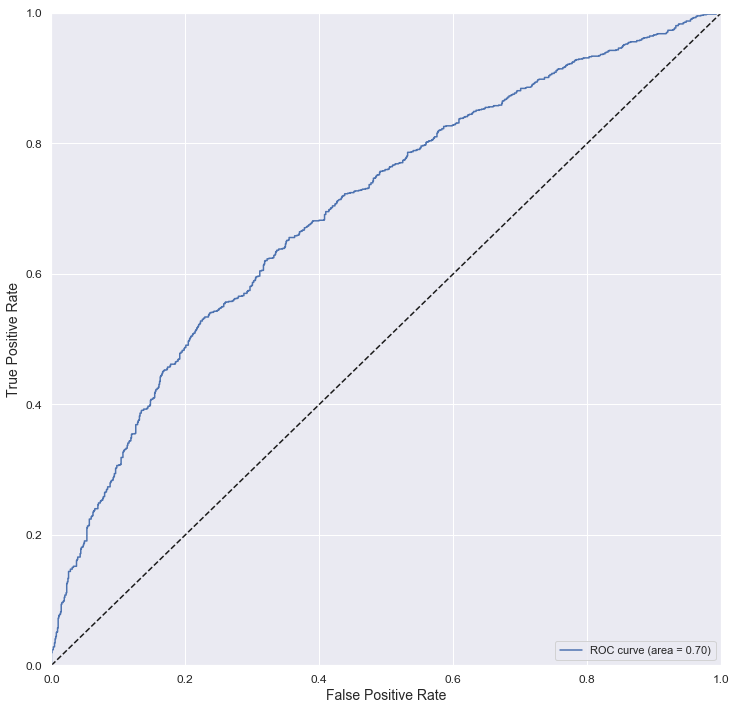

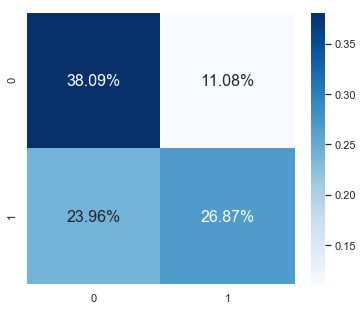

Accuracy_train:  0.6427		Accuracy_test:   0.6496
Precision_test:  0.7080		Recall_test:     0.5287
ROC-AUC_test:    0.6992		F1_test:         0.6054		MCC_test: 0.3125


In [166]:
sns.set()
fitted_class_mdls = {}
fitted_class_mdls['keras_reg'] =\
        mldatasets.evaluate_class_mdl(nn_grid_result.best_estimator_, X_train.astype(float),\
                  X_test.astype(float), y_train.astype(float), y_test.astype(float),\
                  plot_roc=False, plot_conf_matrix=True, ret_eval_dict=True)
fitted_class_mdls['keras_reg']['cv_results'] =\
                                        nn_grid_result.cv_results_
fitted_class_mdls['keras_reg']['cv_best_params'] =\
                                        nn_grid_result.best_params_

In [189]:
class_mdls = {
    'logistic':{'model':linear_model.LogisticRegression(random_state=rand,\
                                                        max_iter=1000),\
                'grid':{'C':np.linspace(0.01, 0.49, 25),\
                        'class_weight':[{0:6,1:5}],\
                        'solver':['lbfgs', 'liblinear', 'newton-cg']}},\
    'svc':{'model':svm.SVC(probability=True, random_state=rand),\
           'grid':{'C':[15,25,40], 'class_weight':[{0:6,1:5}]}},\
    'nu-svc':{'model':svm.NuSVC(probability=True, random_state=rand),\
              'grid':{'nu':[0.2,0.3], 'gamma':[0.6,0.7],\
                      'class_weight':[{0:6,1:5}]}},\
    'mlp':{'model':neural_network.MLPClassifier(random_state=rand,\
                        hidden_layer_sizes=(80,), early_stopping=True),\
           'grid':{'alpha':np.linspace(0.05, 0.15, 11),\
                   'activation':['relu','tanh','logistic']}},\
    'rf':{'model':ensemble.RandomForestClassifier(random_state=rand,\
                        max_depth=7, oob_score=True, bootstrap=True),\
          'grid':{'max_features':[6,7,8], 'max_samples':[0.75,0.9,1],\
                  'class_weight':[{0:6,1:5}]}},\
    'xgb-rf':{'model':xgb.XGBRFClassifier(seed=rand, eta=1, max_depth=7,
                                          n_estimators=200),\
              'grid':{'scale_pos_weight':[0.85], 'reg_lambda':[1,1.5,2],\
                      'reg_alpha':[0,0.5,0.75,1]}},\
    'xgb':{'model':xgb.XGBClassifier(seed=rand, eta=1, max_depth=7),\
           'grid':{'scale_pos_weight':[0.7], 'reg_lambda':[1,1.5,2],\
                   'reg_alpha':[0.5,0.75,1]}},\
    'lgbm':{'model':lgb.LGBMClassifier(random_seed=rand, learning_rate=0.7,\
                                       max_depth=5),\
            'grid':{'lambda_l2':[0,0.5,1], 'lambda_l1':[0,0.5,1],\
                    'scale_pos_weight':[0.8]}},\
    'catboost':{'model':cb.CatBoostClassifier(random_seed=rand, depth=5,\
                                              learning_rate=0.5, verbose=0),\
                'grid':{'l2_leaf_reg':[2,2.5,3], 'scale_pos_weight':[0.65]}}
}

In [ ]:
for mdl_name in class_mdls:
    print(mdl_name)
    base_mdl = copy.deepcopy(class_mdls[mdl_name]['model'])
    base_mdl = base_mdl.fit(X_train, y_train)
    fitted_class_mdls[mdl_name+'_base'] =\
            mldatasets.evaluate_class_mdl(base_mdl, X_train,\
                    X_test, y_train, y_test, plot_roc=False,\
                    plot_conf_matrix=False, show_summary=False,\
                    ret_eval_dict=True)
    
    reg_mdl = copy.deepcopy(class_mdls[mdl_name]['model'])
    grid = class_mdls[mdl_name]['grid']
    cv = model_selection.RepeatedStratifiedKFold(n_splits=5,\
                                n_repeats=3, random_state=rand)
    grid_search = model_selection.GridSearchCV(estimator=reg_mdl,\
                        cv=cv, param_grid=grid, scoring='precision',\
                        n_jobs=-1, error_score=0, verbose=0)
    grid_result = grid_search.fit(X_train, y_train)
    fitted_class_mdls[mdl_name+'_reg'] =\
            mldatasets.evaluate_class_mdl(grid_result.best_estimator_,\
                    X_train, X_test, y_train, y_test, plot_roc=False,\
                    plot_conf_matrix=False, show_summary=False,\
                    ret_eval_dict=True)
    fitted_class_mdls[mdl_name+'_reg']['cv_results'] =\
                                                grid_result.cv_results_
    fitted_class_mdls[mdl_name+'_reg']['cv_best_params'] =\
                                                grid_result.best_params_

In [ ]:
class_metrics = pd.DataFrame.from_dict(fitted_class_mdls,\
                'index')[['accuracy_train', 'accuracy_test',\
                          'precision_train', 'precision_test',\
                          'recall_train', 'recall_test',\
                          'roc-auc_test', 'f1_test', 'mcc_test']]
with pd.option_context('display.precision', 3):
    html = class_metrics.sort_values(by='precision_test', ascending=False).\
        style.background_gradient(cmap='plasma', subset=['precision_test']).\
        background_gradient(cmap='viridis', subset=['recall_test'])
html

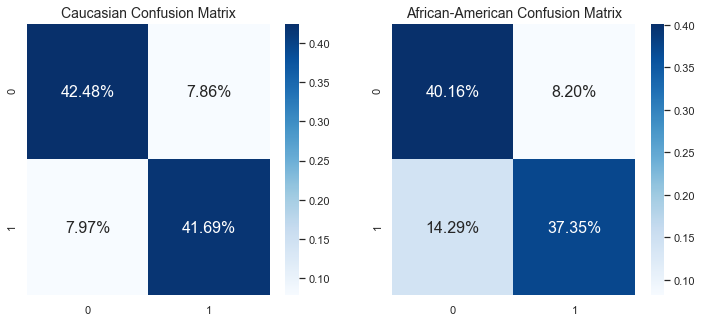

	African-American FPR:	16.9%
	Caucasian FPR:		15.6%
	Ratio FPRs:		1.09 x


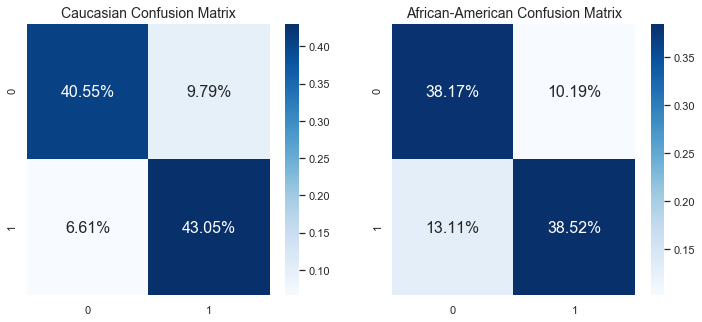

	African-American FPR:	21.1%
	Caucasian FPR:		19.5%
	Ratio FPRs:		1.08 x


In [48]:
y_test_pred = fitted_class_mdls['catboost_reg']['preds_test']
_ = mldatasets.\
        compare_confusion_matrices(y_test[X_test.race==1], y_test_pred[X_test.race==1],\
                                   y_test[X_test.race==0], y_test_pred[X_test.race==0],\
                                   'Caucasian', 'African-American', compare_fpr=True)

y_test_pred = fitted_class_mdls['catboost_base']['preds_test']
_ = mldatasets.\
        compare_confusion_matrices(y_test[X_test.race==1], y_test_pred[X_test.race==1],\
                                   y_test[X_test.race==0], y_test_pred[X_test.race==0],\
                                   'Caucasian', 'African-American', compare_fpr=True)

In [288]:
def weighted_penalized_pr_average(y_true, y_pred, X_group, group_vals,\
                                  penalty_mult=0.5, precision_mult=2, recall_mult=1):
    precision_all = metrics.precision_score(y_true,\
                                            y_pred, zero_division=0)
    recall_all = metrics.recall_score(y_true,\
                                      y_pred, zero_division=0)
    p_by_group = []
    r_by_group = []
    for group_val in group_vals:
        in_group = X_group==group_val
        p_by_group.append(metrics.\
                         precision_score(y_true[in_group],\
                                         y_pred[in_group], zero_division=0))
        r_by_group.append(metrics.\
                         recall_score(y_true[in_group],\
                                      y_pred[in_group], zero_division=0))
        
    precision_all = precision_all - (np.array(p_by_group).std()*penalty_mult)
    recall_all = recall_all - (np.array(r_by_group).std()*penalty_mult)
    return ((precision_all*precision_mult)+(recall_all*recall_mult))/\
            (precision_mult+recall_mult)

In [304]:
def hyp_catboost(l2_leaf_reg, scale_pos_weight):
    cv = model_selection.RepeatedStratifiedKFold(n_splits=4,\
                                n_repeats=3, random_state=rand)
    metric_l = []
    for train_index, val_index in cv.split(X_train, y_train):
        X_train_cv, X_val_cv = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]
        mdl = cb.CatBoostClassifier(random_seed=rand,learning_rate=0.5, verbose=0,\
                                    depth=5, l2_leaf_reg=l2_leaf_reg,\
                                    scale_pos_weight=scale_pos_weight)
        mdl = mdl.fit(X_train_cv, y_train_cv)
        y_val_pred = mdl.predict(X_val_cv)
        metric = weighted_penalized_pr_average(y_val_cv, y_val_pred,\
                                                X_val_cv['race'], range(3))
        metric_l.append(metric)
    return np.median(np.array(metric_l))

In [290]:
pbounds = {
            'l2_leaf_reg': (2,4),
            'scale_pos_weight': (0.55,0.85)
          }
optimizer = BayesianOptimization(hyp_catboost, pbounds, random_state=rand)
optimizer.maximize(init_points=3, n_iter=7)

|   iter    |  target   | l2_lea... | scale_... |
-------------------------------------------------
|  1        |  0.7683   |  2.021    |  0.7006   |
|  2        |  0.7656   |  2.992    |  0.5901   |
|  3        |  0.766    |  2.284    |  0.6156   |
|  4        |  0.7632   |  2.744    |  0.8045   |
|  5        |  0.7594   |  2.917    |  0.6475   |
|  6        |  0.7653   |  3.787    |  0.7465   |
|  7        |  0.7637   |  3.043    |  0.8094   |
|  8        |  0.761    |  2.162    |  0.5572   |
|  9        |  0.7567   |  2.047    |  0.6749   |
|  10       |  0.7606   |  3.583    |  0.6271   |
CPU times: user 24min 4s, sys: 1min 40s, total: 25min 44s
Wall time: 6min 32s


In [291]:
print(optimizer.max['params'])

{'l2_leaf_reg': 2.0207483077713997, 'scale_pos_weight': 0.7005623776446217}

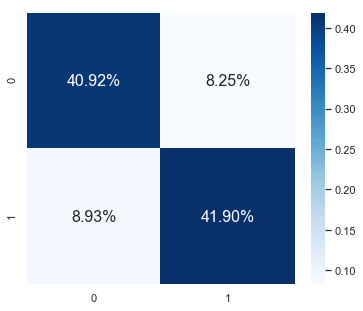

Accuracy_train:  0.9721		Accuracy_test:   0.8282
Precision_test:  0.8354		Recall_test:     0.8244
ROC-AUC_test:    0.8815		F1_test:         0.8299		MCC_test: 0.6564


In [308]:
cb_opt = cb.CatBoostClassifier(random_seed=rand, depth=5,learning_rate=0.5,\
                               verbose=0, **optimizer.max['params'])
cb_opt = cb_opt.fit(X_train, y_train)
fitted_class_mdls['catboost_opt'] =\
        mldatasets.evaluate_class_mdl(cb_opt, X_train, X_test, y_train, y_test,\
                  plot_roc=False, plot_conf_matrix=True, ret_eval_dict=True)

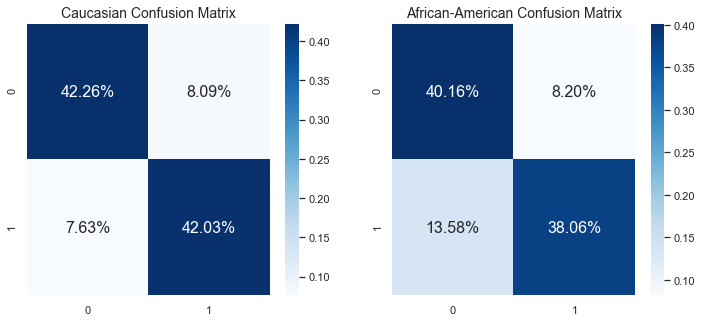

	African-American FPR:	16.9%
	Caucasian FPR:		16.1%
	Ratio FPRs:		1.06 x


In [309]:
y_test_pred = fitted_class_mdls['catboost_opt']['preds_test']
_ = mldatasets.\
        compare_confusion_matrices(y_test[X_test.race==1], y_test_pred[X_test.race==1],\
                                   y_test[X_test.race==0], y_test_pred[X_test.race==0],\
                                   'Caucasian', 'African-American', compare_fpr=True)

In [392]:
fitted_cb_mdl = fitted_class_mdls['catboost_opt']['fitted']
shap_cb_explainer = shap.TreeExplainer(fitted_xgb_mdl)
shap_cb_values = shap_xgb_explainer.shap_values(X_test)

fitted_xgb_mdl = fitted_class_mdls['xgb_reg']['fitted']
shap_xgb_explainer = shap.TreeExplainer(fitted_xgb_mdl)
shap_xgb_values = shap_xgb_explainer.shap_values(X_test)

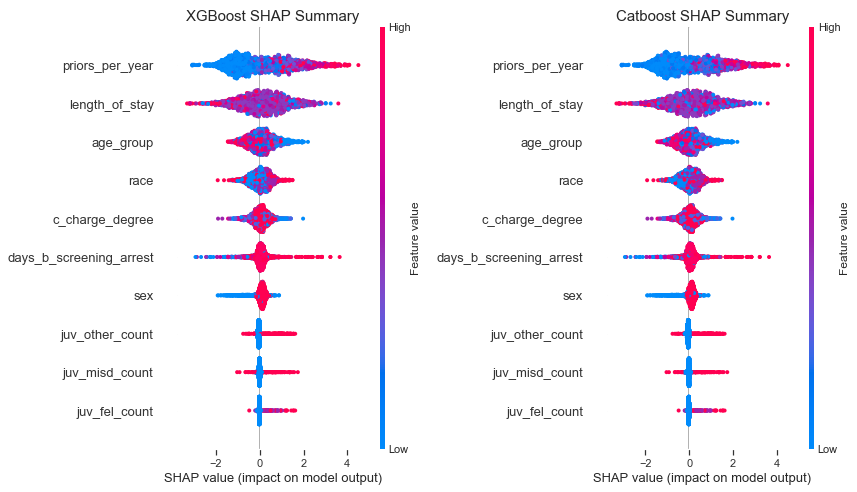

In [403]:
plt.figure(figsize=(12,7))

ax0 = plt.subplot(1, 2, 1)
shap.summary_plot(shap_xgb_values, X_test, plot_type="dot",\
                  plot_size=None, show=False)
ax0.set_title("XGBoost SHAP Summary", fontsize=15)

ax1 = plt.subplot(1, 2, 2)
shap.summary_plot(shap_cb_values, X_test, plot_type="dot",\
                  plot_size=None, show=False)
ax1.set_title("Catboost SHAP Summary", fontsize=15)

plt.tight_layout()
plt.subplots_adjust(wspace=0.8)
plt.show()

In [ ]:
shap_xgb_interact_values = shap_xgb_explainer.shap_interaction_values(X_test)

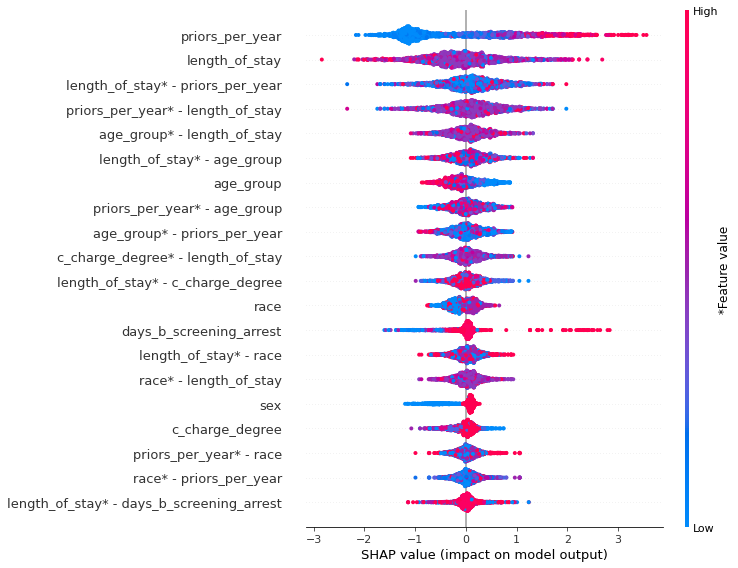

In [48]:
shap.summary_plot(shap_xgb_interact_values, X_test,\
                  plot_type="compact_dot", sort=True)

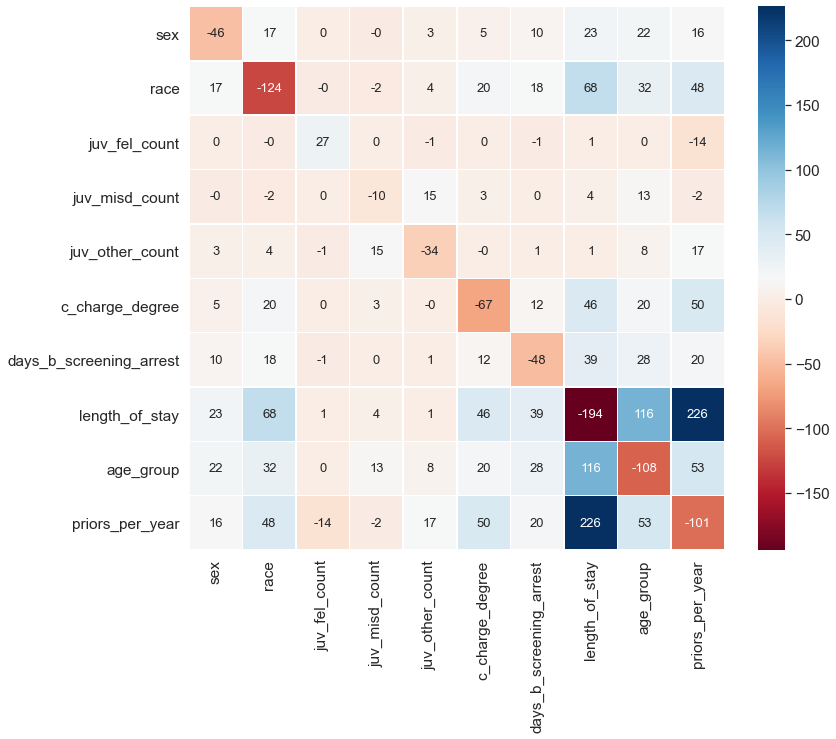

In [84]:
shap_xgb_interact_df = pd.DataFrame(np.sum(shap_xgb_interact_values, axis=0))
shap_xgb_interact_df.columns = X_test.columns
shap_xgb_interact_df.index = X_test.columns

plt.figure(figsize=(12,10))
sns.set(font_scale=1.4)
sns.heatmap(shap_xgb_interact_df, cmap='RdBu', annot=True,\
            annot_kws={'size':13}, fmt='.0f', linewidths=.5)
plt.show()

In [522]:
X_train_con = X_train.drop(['race'], axis=1).copy()
X_test_con = X_test.drop(['race'], axis=1).copy()

In [ ]:
print(fitted_class_mdls['xgb_reg']['cv_best_params'])

In [ ]:
best_xgb_params = {'eta': 1.3, 'max_depth': 8, 'reg_alpha': 0.4451,\
                   'reg_lambda': 0.7168, 'scale_pos_weight': 0.9914}
mono_con = (0,0,0,0,0,0,0,0,1)
interact_con = [[4, 5, 6, 7, 8],[0, 1, 2, 3]]

Accuracy_train:  0.9330		Accuracy_test:   0.7932
Precision_test:  0.7932		Recall_test:     0.8023
ROC-AUC_test:    0.8628		F1_test:         0.7977		MCC_test: 0.5862


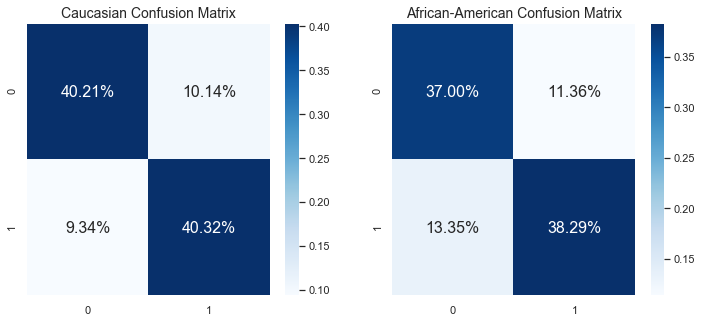

	African-American FPR:	23.5%
	Caucasian FPR:		20.1%
	Ratio FPRs:		1.17 x


In [524]:
xgb_con = xgb.XGBClassifier(seed=rand,\
                            monotone_constraints=mono_con,\
                            interaction_constraints=interact_con,\
                            **best_xgb_params)
xgb_con = xgb_con.fit(X_train_con, y_train)
fitted_class_mdls['xgb_con'] =\
        mldatasets.evaluate_class_mdl(xgb_con, X_train_con, X_test_con,\
                                      y_train, y_test, plot_roc=False,\
                                      ret_eval_dict=True)
y_test_pred = fitted_class_mdls['xgb_con']['preds_test']
_ = mldatasets.\
            compare_confusion_matrices(y_test[X_test.race==1], y_test_pred[X_test.race==1],\
                                       y_test[X_test.race==0], y_test_pred[X_test.race==0],\
                                       'Caucasian', 'African-American', compare_fpr=True)

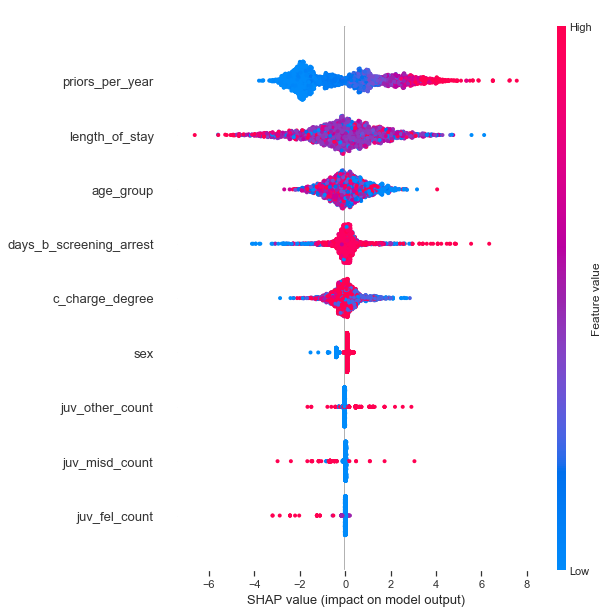

In [527]:
fitted_xgb_con_mdl = fitted_class_mdls['xgb_con']['fitted']
shap_xgb_con_explainer = shap.TreeExplainer(fitted_xgb_con_mdl)
shap_xgb_con_values = shap_xgb_con_explainer.shap_values(X_test_con)
shap.summary_plot(shap_xgb_con_values, X_test_con, plot_type="dot", show=False)
fig = plt.gcf()
fig.set_size_inches(8,10)
plt.show()

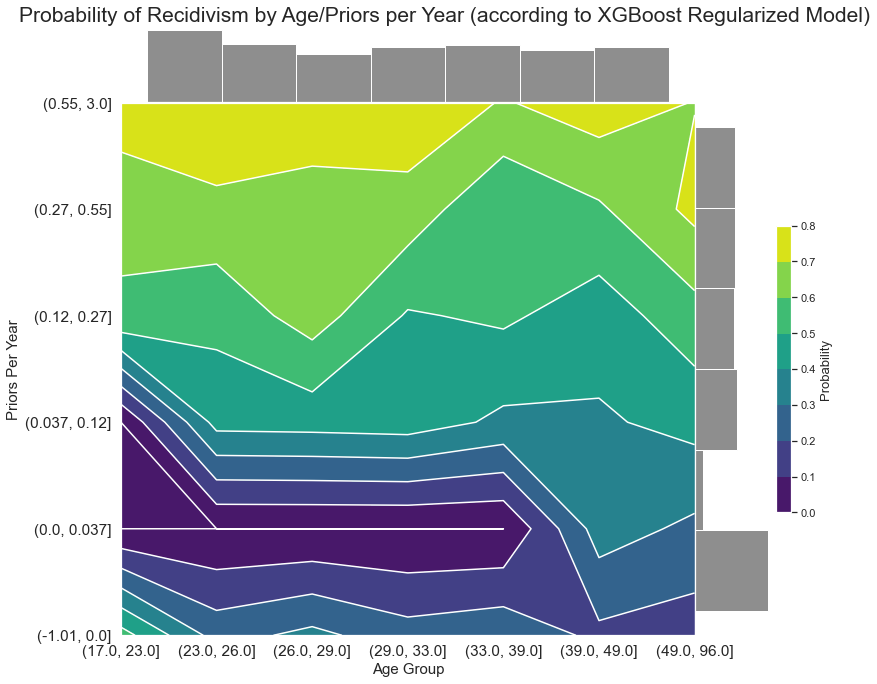

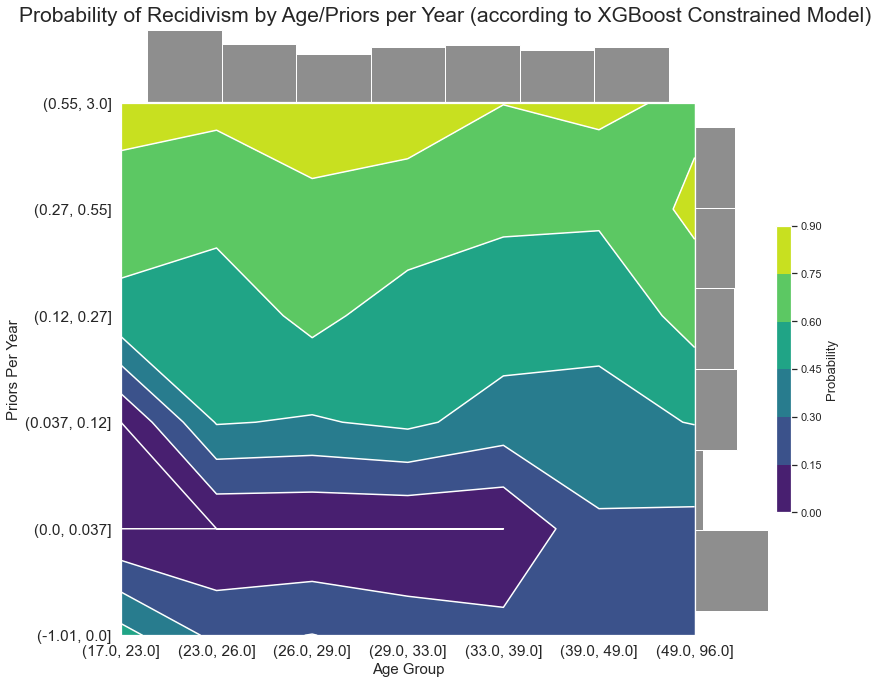

In [141]:
mldatasets.plot_prob_contour_map(recidivism_df.age_group, recidivism_df.priors_per_year,\
                                 recidivism_df.is_recid, x_intervals=ordenc.categories_[2],\
                                 y_intervals=6, use_quartiles=True, xlabel='Age Group',\
                                 ylabel='Priors Per Year', X_df=X_test, x_col='age_group',\
                                 y_col='priors_per_year', model=fitted_xgb_mdl,\
                title='Probability of Recidivism by Age/Priors per Year (according to XGBoost Regularized Model)')

mldatasets.plot_prob_contour_map(recidivism_df.age_group, recidivism_df.priors_per_year,\
                                 recidivism_df.is_recid, x_intervals=ordenc.categories_[2],\
                                 y_intervals=6, use_quartiles=True, xlabel='Age Group',\
                                 ylabel='Priors Per Year', X_df=X_test_con, x_col='age_group',\
                                 y_col='priors_per_year', model=fitted_xgb_con_mdl,\
                title='Probability of Recidivism by Age/Priors per Year (according to XGBoost Constrained Model)')

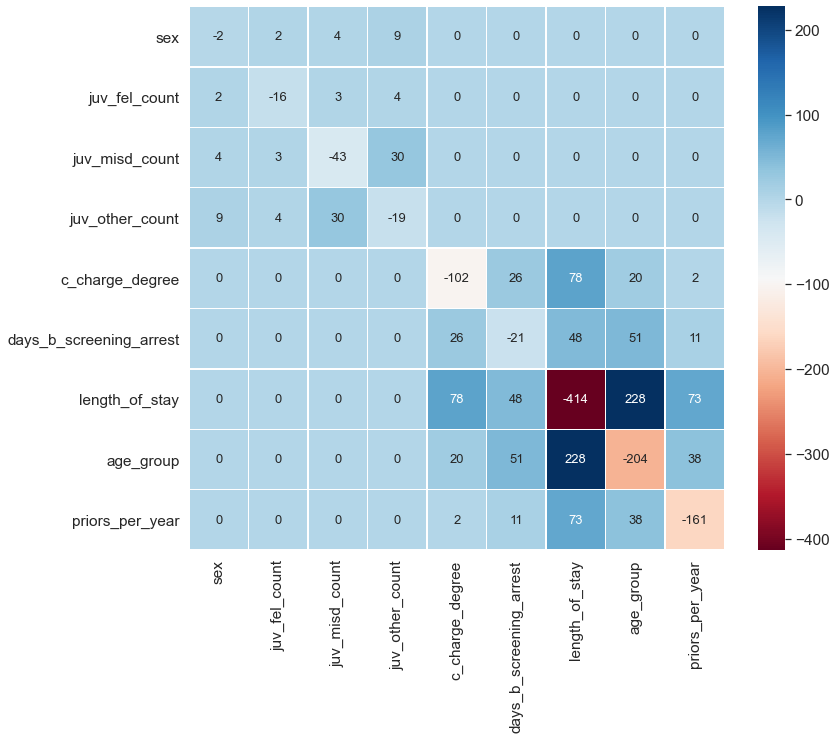

In [123]:
shap_xgb_interact_values = shap_xgb_con_explainer.shap_interaction_values(X_test_con)
shap_xgb_interact_df = pd.DataFrame(np.sum(shap_xgb_interact_values, axis=0))
shap_xgb_interact_df.columns = X_test_con.columns
shap_xgb_interact_df.index = X_test_con.columns

plt.figure(figsize=(12,10))
sns.set(font_scale=1.4)
sns.heatmap(shap_xgb_interact_df, cmap='RdBu', annot=True,\
            annot_kws={'size':13}, fmt='.0f', linewidths=.5)
plt.show()

In [17]:
lattice_sizes = [2, 2, 2, 2, 3, 5, 7, 7, 6] 

In [155]:
model_inputs = []
lattice_inputs = []

sex_input = tf.keras.layers.Input(shape=[1], name='sex')
lattice_inputs.append(tfl.layers.CategoricalCalibration(
        name='sex_calib',
        num_buckets=2,
        output_min=0.0,
        output_max=lattice_sizes[0] - 1.0,
        kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.001),
        kernel_initializer='constant')(sex_input))
model_inputs.append(sex_input)

juvf_input = tf.keras.layers.Input(shape=[1], name='juv_fel_count')
lattice_inputs.append(tfl.layers.PWLCalibration(
        name='juvf_calib',
        input_keypoints=np.linspace(0, 20, num=5, dtype=np.float32),
        output_min=0.0,
        output_max=lattice_sizes[1] - 1.0,
        monotonicity='none',
        kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.001),
        kernel_initializer='equal_slopes')(juvf_input))
model_inputs.append(juvf_input)

juvm_input = tf.keras.layers.Input(shape=[1], name='juv_misd_count')
lattice_inputs.append(tfl.layers.PWLCalibration(
        name='juvm_calib',
        input_keypoints=np.linspace(0, 13, num=5, dtype=np.float32),
        output_min=0.0,
        output_max=lattice_sizes[2] - 1.0,
        monotonicity='none',
        kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.001),
        kernel_initializer='equal_slopes')(juvm_input))
model_inputs.append(juvm_input)

juvo_input = tf.keras.layers.Input(shape=[1], name='juv_other_count')
lattice_inputs.append(tfl.layers.PWLCalibration(
        name='juvo_calib',
        input_keypoints=np.linspace(0, 11, num=5, dtype=np.float32),
        output_min=0.0,
        output_max=lattice_sizes[3] - 1.0,
        monotonicity='none',
        kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.001),
        kernel_initializer='equal_slopes')(juvo_input))
model_inputs.append(juvo_input)

charge_input = tf.keras.layers.Input(shape=[1], name='c_charge_degree')
lattice_inputs.append(tfl.layers.PWLCalibration(
        name='charge_calib',
        input_keypoints=np.quantile(X_train_con['c_charge_degree'],\
                                    np.linspace(0, 1, num=4)),
        output_min=0.0,
        output_max=lattice_sizes[4] - 1.0,
        monotonicity='none',
        kernel_regularizer=('hessian', 0.0, 1e-4))(charge_input))
model_inputs.append(charge_input)

days_input = tf.keras.layers.Input(shape=[1], name='days_b_screening_arrest')
lattice_inputs.append(tfl.layers.PWLCalibration(
        name='days_calib',
        input_keypoints=np.linspace(-30, 30, num=6, dtype=np.float32),
        output_min=0.0,
        output_max=lattice_sizes[5] - 1.0,
        monotonicity='none',
        kernel_regularizer=('hessian', 0.0, 1e-4))(days_input))
model_inputs.append(days_input)

length_input = tf.keras.layers.Input(shape=[1], name='length_of_stay')
lattice_inputs.append(tfl.layers.PWLCalibration(
        name='length_calib',
        input_keypoints=np.quantile(X_train_con['length_of_stay'],\
                                    np.linspace(0, 1, num=8)),
        output_min=0.0,
        output_max=lattice_sizes[6] - 1.0,
        monotonicity='none',
        kernel_regularizer=('hessian', 0.0, 1e-4))(length_input))
model_inputs.append(length_input)

age_input = tf.keras.layers.Input(shape=[1], name='age_group')
lattice_inputs.append(tfl.layers.PWLCalibration(
        name='age_calib',
        input_keypoints=np.linspace(0, 6, num=7, dtype=np.float32),
        output_min=0.0,
        output_max=lattice_sizes[7] - 1.0,
        monotonicity='none',
        kernel_regularizer=('hessian', 0.0, 1e-4))(age_input))
model_inputs.append(age_input)

priors_input = tf.keras.layers.Input(shape=[1], name='priors_per_year')
lattice_inputs.append(tfl.layers.PWLCalibration(
        name='priors_calib',
        input_keypoints=np.quantile(X_train_con['priors_per_year'],\
                                    np.linspace(0, 1, num=7)),
        output_min=0.0,
        output_max=lattice_sizes[8] - 1.0,
        monotonicity='increasing')(priors_input))
model_inputs.append(priors_input)

In [156]:
lattice = tfl.layers.Lattice(
                        name='lattice',
                        lattice_sizes=lattice_sizes,
                        monotonicities=[
                            'none', 'none', 'none', 'none', 'none',
                            'none', 'none', 'none', 'increasing'
                        ],
                        output_min=0.0,
                        output_max=1.0)(lattice_inputs)

model_output = tf.keras.layers.Dense(1, name='output',\
                                     activation='sigmoid')(lattice)

In [157]:
tfl_mdl = tf.keras.models.Model(\
                inputs=model_inputs,\
                outputs=model_output)

In [ ]:
tfl_mdl.summary()

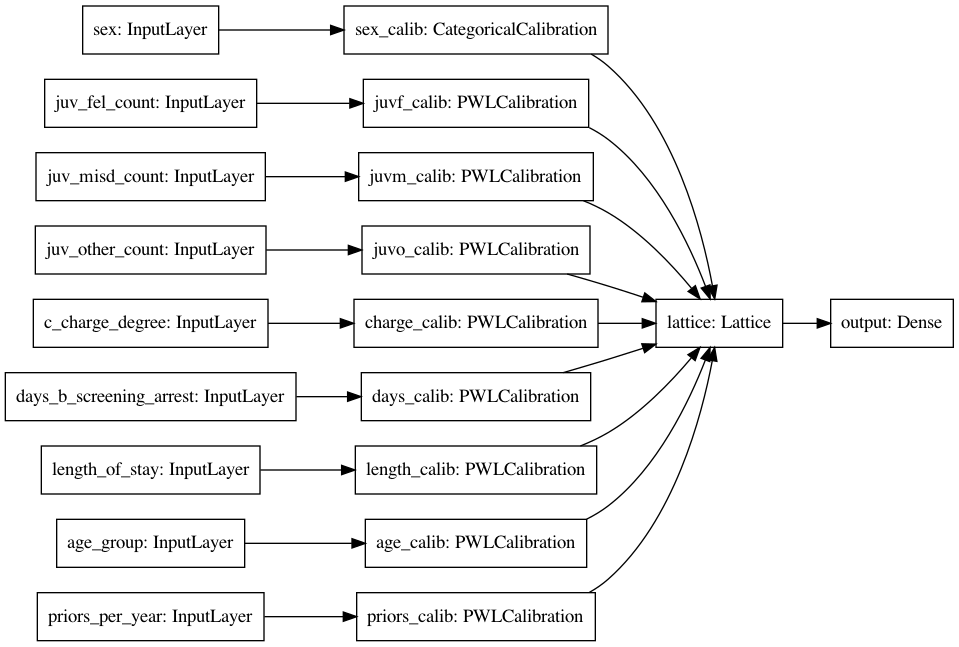

In [76]:
tf.keras.utils.plot_model(tfl_mdl, rankdir='LR')

In [158]:
tfl_mdl.compile(loss='binary_crossentropy',\
                optimizer=tf.keras.optimizers.Adam(lr=0.004),\
                metrics=['accuracy',tf.keras.metrics.AUC(name='auc')])

In [159]:
X_train_expand = np.split(\
                        X_train_con.values.astype(np.float32),\
                        indices_or_sections=9, axis=1)
y_train_expand = np.expand_dims(y_train.values.astype(np.float32), axis=1)
X_test_expand = np.split(\
                        X_test_con.values.astype(np.float32),\
                        indices_or_sections=9, axis=1)
y_test_expand = np.expand_dims(y_test.values.astype(np.float32), axis=1)

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', verbose=1,\
                                patience=20, restore_best_weights=True) 
tfl_history = tfl_mdl.fit(X_train_expand, y_train_expand,\
                          class_weight={0:18, 1:16},
                          batch_size=128, epochs=60, validation_split=0.2,\
                          shuffle=False, callbacks=[es], verbose=1)

Accuracy_train:  0.7453		Accuracy_test:   0.7057
Precision_test:  0.7387		Recall_test:     0.6514
ROC-AUC_test:    0.7651		F1_test:         0.6923		MCC_test: 0.4154


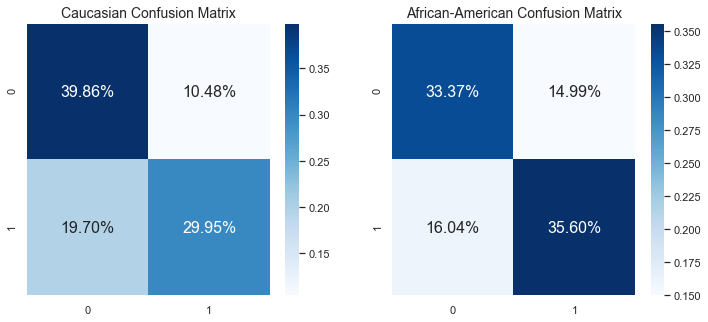

	African-American FPR:	31.0%
	Caucasian FPR:		20.8%
	Ratio FPRs:		1.49 x


In [161]:
fitted_class_mdls['tfl_con'] =\
    mldatasets.evaluate_class_mdl(tfl_mdl, X_train_expand,\
                                  X_test_expand,\
                                  y_train.values.astype(np.float32),\
                                  y_test.values.astype(np.float32),\
                                  plot_roc=False, ret_eval_dict=True)
y_test_pred = fitted_class_mdls['tfl_con']['preds_test']
_ = mldatasets.\
            compare_confusion_matrices(y_test[X_test.race==1], y_test_pred[X_test.race==1],\
                                       y_test[X_test.race==0], y_test_pred[X_test.race==0],\
                                       'Caucasian', 'African-American', compare_fpr=True)

In [ ]:
for mdl_name in fitted_class_mdls:
    fitted_class_mdls[mdl_name]['wppra_test'] =\
            weighted_penalized_pr_average(y_test,\
                                          fitted_class_mdls[mdl_name]['preds_test'],\
                                          X_test['race'], range(3))

class_metrics = pd.DataFrame.from_dict(fitted_class_mdls,\
                    'index')[['precision_test', 'recall_test', 'wppra_test']]
with pd.option_context('display.precision', 3):
    html = class_metrics.sort_values(by='wppra_test', ascending=False).\
        style.background_gradient(cmap='plasma', subset=['precision_test']).\
        background_gradient(cmap='viridis', subset=['recall_test'])
html

![png](./Chapter12_files_extra/Fig_24.png)